In [201]:
import numpy as np
import matplotlib.pyplot as plt

In [225]:
norm = 2000
#Simulation parameters
richNeighbourhoods = 3
poorNeighbourhoods = 10
richPeople = 200
poorPeople = 300
richVisitRich = 10
richVisitPoor = 2 
poorVisitPoor = 5
poorVisitRich = 3
richSpend = 200
poorSpend = 50
radiusPenalty = 1
locationPenalty = 1
iterations = 365

totalNeighbourhoods = richNeighbourhoods + poorNeighbourhoods
totalPopulation = richPeople + poorPeople
richDistribution = np.append(np.full(richNeighbourhoods,richVisitRich),np.full(poorNeighbourhoods,richVisitPoor))
poorDistribution = np.append(np.full(richNeighbourhoods,poorVisitRich),np.full(poorNeighbourhoods,poorVisitPoor))
#Annealing parameters 


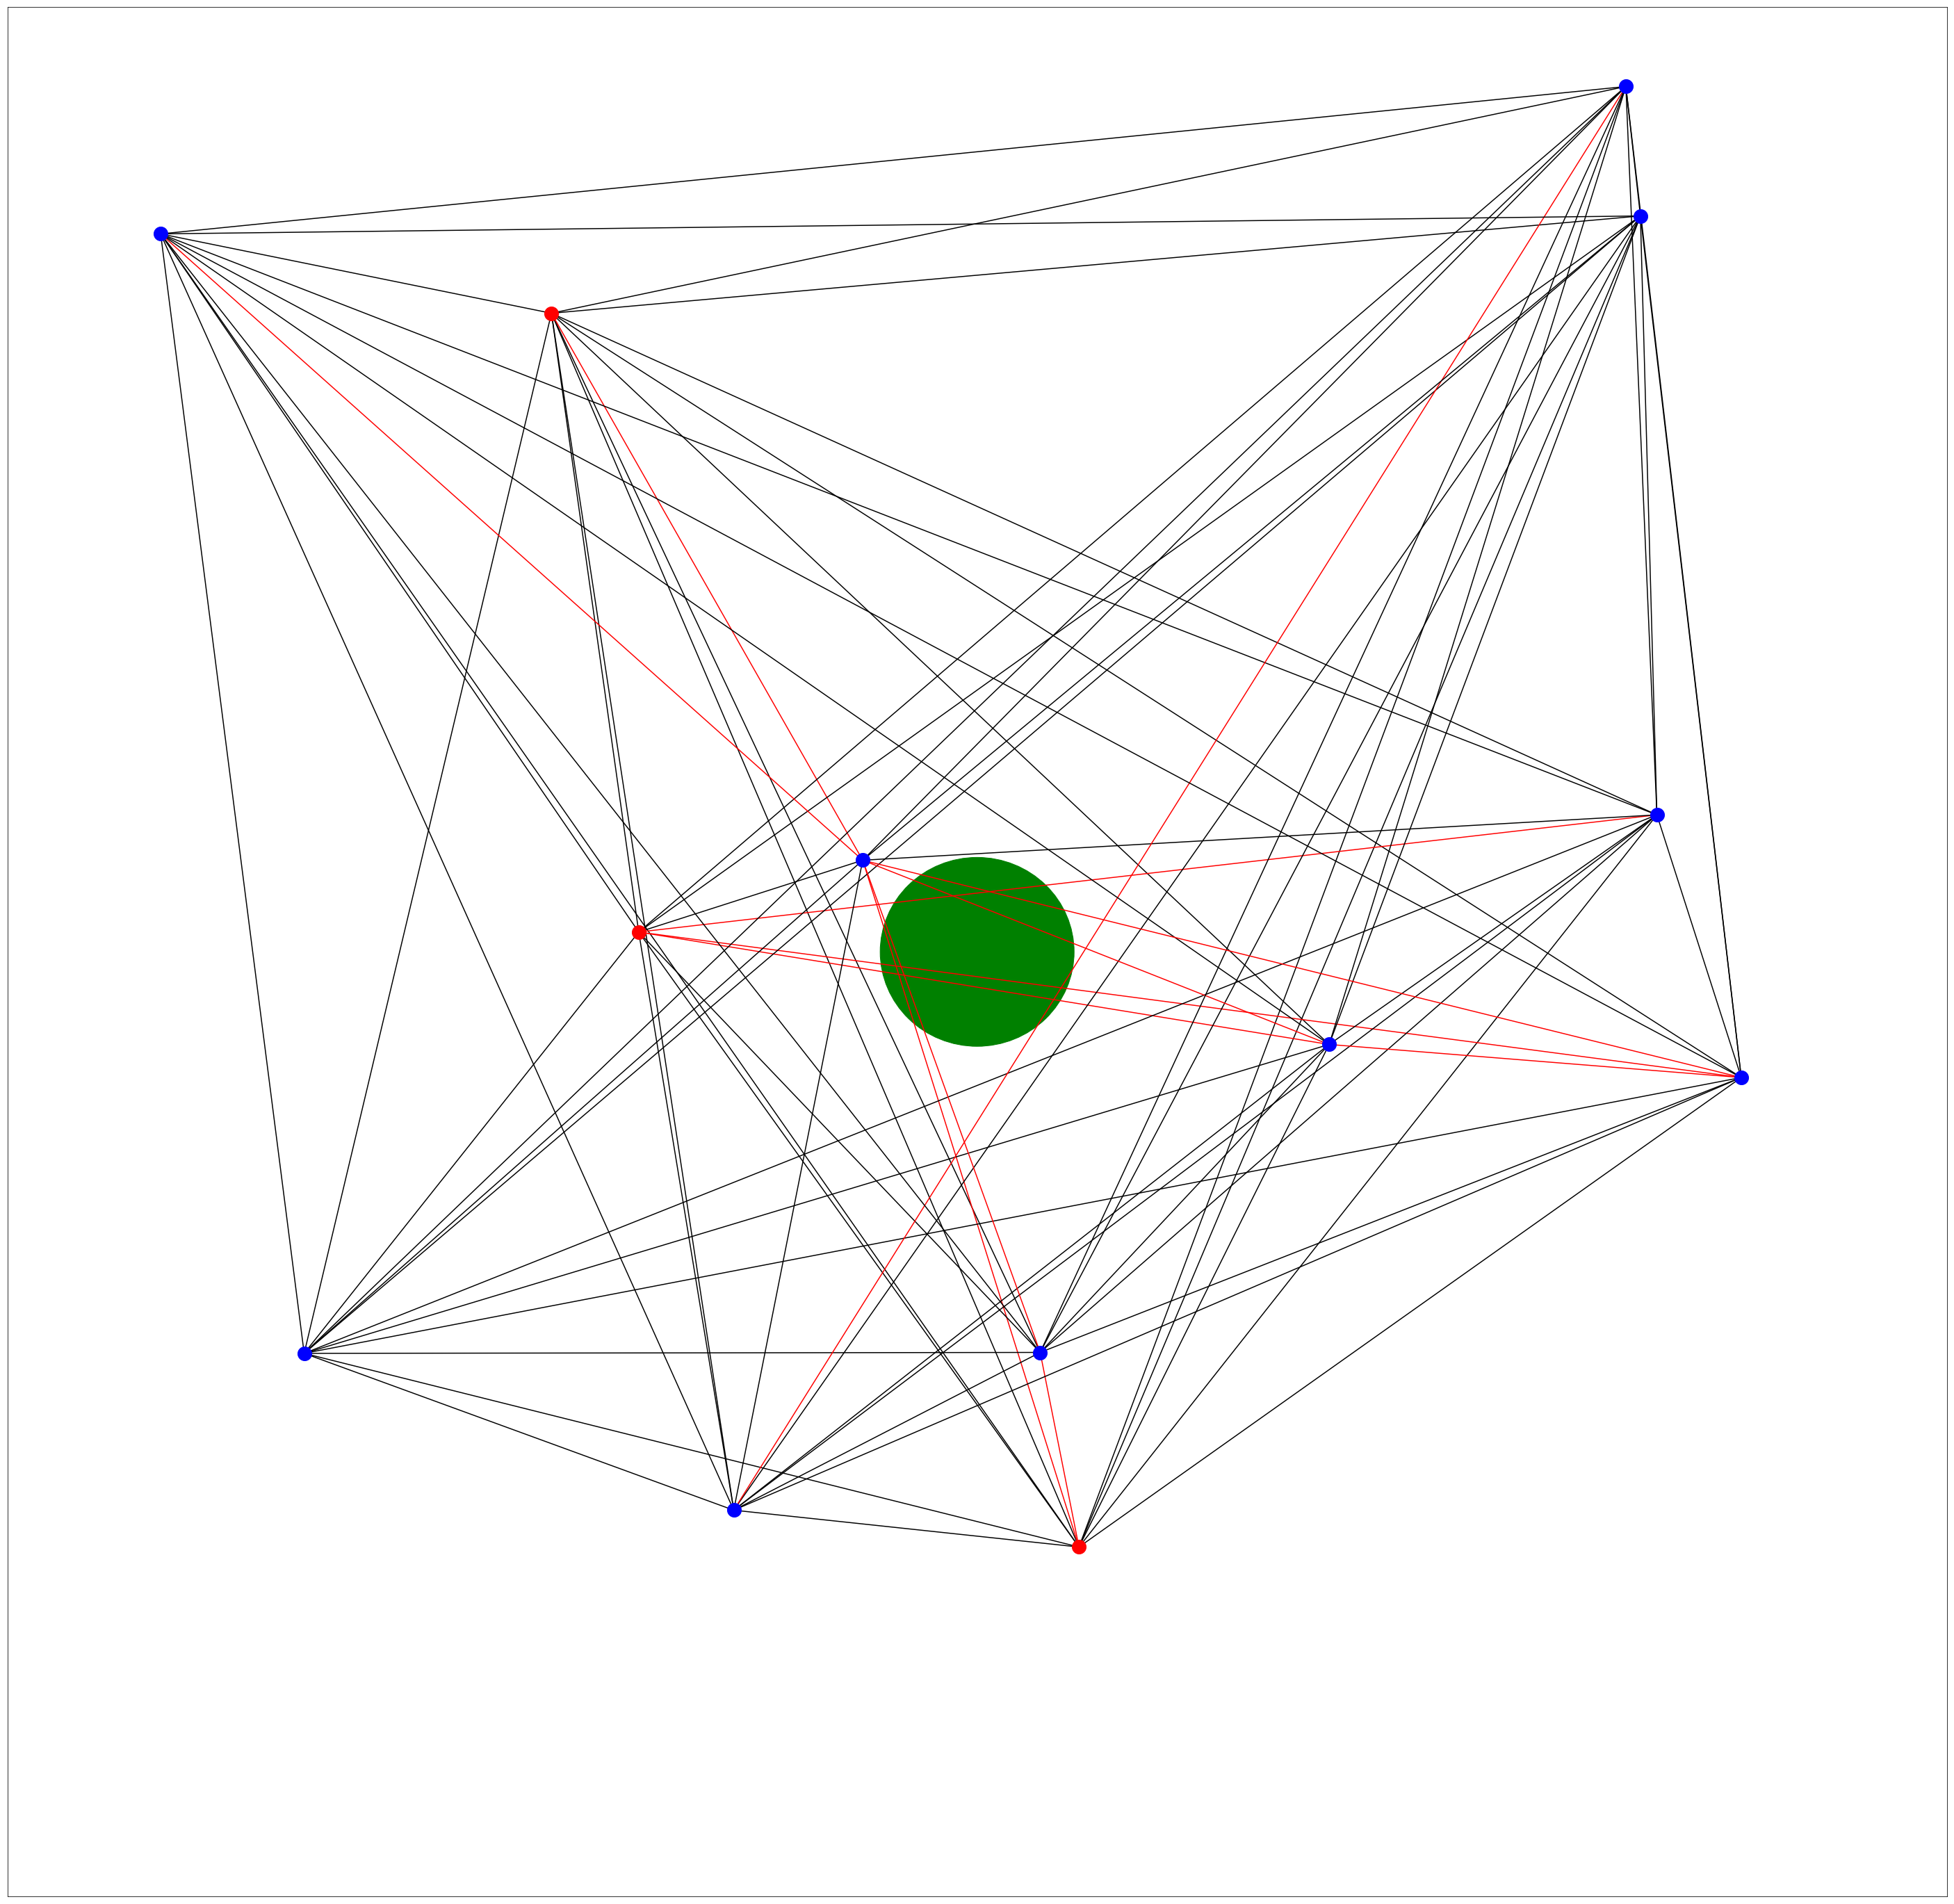

In [264]:
def generateNeighbourhoods(nNeighbourhoods):
    x = np.random.randint(0,norm,nNeighbourhoods)
    y = np.random.randint(0,norm,nNeighbourhoods)
    return x,y

xp,yp = generateNeighbourhoods(poorNeighbourhoods)
xr,yr = generateNeighbourhoods(richNeighbourhoods)

x = np.append(xr,xp)
y = np.append(yr,yp)

def connect(x,y,p1,p2,color='k'):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],color+'-')
    
def intersects(x,y,p1,p2,cx,cy,cr):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    x1 -= cx
    x2 -= cx
    y1 -= cy
    y2 -= cy
    dx = x2 - x1
    dy = y2 - y1
    dr_squared = dx**2 + dy**2
    D = x1*y2 - x2*y1
    return cr**2 * dr_squared >= D**2

visibileRoutes = set()

def drawRoutes(x,y):
    for i in range(0,len(x)):
        for j in range(i,len(x)):
            if(intersects(x,y,i,j,norm/2,norm/2,100)):
                visibileRoutes.add((i,j));
                visibileRoutes.add((j,i));
                connect(x,y,i,j,color='r')
            else:
                connect(x,y,i,j,color='k')

#graph is complete so all edges are n(n-1)/2 -> complexity for checking if an agent
#could visit the shop is O(n^2) in space and O(n^2) in time lookup(table)
#total time complexity should be O(n^2*iterations)

#Metropolis-Hastings
def MetropolisHastings(neighbours,direction_probability,stationary_distribution):
    states = len(neighbours.keys())
    MH_mat = np.zeros((states,states))
    proposal_mat = np.zeros((states,states))

    for state,adjacent in zip(neighbours.keys(),neighbours.values()):
        for direction in range(len(neighbours.keys())):
            proposal_mat[state,adjacent[direction]] += direction_probability[direction]

    for state,adjacent in zip(neighbours.keys(),neighbours.values()):
        accept_probability = 0.0 #the probability to move to any of the neighbouring states
        for direction in range(len(neighbours.keys())):
            if(adjacent[direction]!=state):
                acceptance_ratio = min(1, \
                    (stationary_distribution[adjacent[direction]]*proposal_mat[adjacent[direction],state])/ \
                    (stationary_distribution[state]*proposal_mat[state,adjacent[direction]]))
                transition_probability = direction_probability[direction]*acceptance_ratio
                accept_probability += transition_probability
                MH_mat[state,adjacent[direction]] = transition_probability
        MH_mat[state,state] = 1-accept_probability
    return MH_mat

def generateMarkovMat(stationary_distribution):
    neighbours = {x:list(range(totalNeighbourhoods)) for x in range(totalNeighbourhoods)}
    direction_probability = np.full(totalNeighbourhoods,1/(totalNeighbourhoods))
    return MetropolisHastings(neighbours,direction_probability,stationary_distribution)
    
richMM = generateMarkovMat(richDistribution)
poorMM = generateMarkovMat(poorDistribution)

#cumulative sums for determining next states
richCS = np.cumsum(richMM,axis=1)
poorCS = np.cumsum(poorMM,axis=1)

agent_rich_state = np.random.randint(0,richNeighbourhoods,richPeople)
agent_poor_state = np.random.randint(richNeighbourhoods,poorNeighbourhoods,poorPeople)
        
def price(x,y,cx,cy):
    p = zip(x,y)
    np.linalg.norm()


plt.figure(figsize=(50, 50))
ax = plt.axes()
ax.set_xlim(0.0,norm), ax.set_xticks([])
ax.set_ylim(0.0, norm), ax.set_yticks([])
drawRoutes(x,y)
cir = plt.Circle((norm/2,norm/2),radius=100, color='green')
ax = plt.gca()
ax.add_artist(cir)
plt.plot(xr,yr,'ro',markersize=20)
plt.plot(xp,yp,'bo',markersize=20)
plt.savefig('asdf.png')

In [262]:
#can probably use 2 agents - one rich and one poor and run the simulation for longer

def step(state,cumsumArray):
    return np.argmax(cumsumArray[state] > np.random.uniform(0,1))

def stepAll(states, markovMat):
     return np.fromiter((step(x,markovMat) for x in states),x.dtype)

# def step(state,markovMat):
#     return np.random.choice(totalNeighbourhoods,p=markovMat[state])

# def stepAll(states,markovMat):
#     return np.fromiter((step(x,markovMat) for x in states),x.dtype)

agent_rich_state_new = np.zeros((1,len(agent_rich_state)))
agent_rich_state_new = np.zeros((1,len(agent_rich_state)))

def simulate():
    richVisits = 0
    poorVisits = 0
    global agent_rich_state
    global agent_poor_state
    for i in range(iterations):
        agent_rich_state_new = stepAll(agent_rich_state,richCS)#richCS)
        agent_poor_state_new = stepAll(agent_poor_state,poorCS)#poorCS)
        for i in zip(agent_rich_state,agent_rich_state_new):
            if (i in visibileRoutes and np.random.uniform(0,1) > 0.5):
                richVisits += 1
        for i in zip(agent_poor_state,agent_poor_state_new):
            if (i in visibileRoutes and np.random.uniform(0,1) > 0.5):
                poorVisits += 1
        agent_rich_state = np.copy(agent_rich_state_new)
        agent_poor_state = np.copy(agent_poor_state_new)
    return richVisits, poorVisits

In [239]:
simulate()

(18187, 13101)